In [2]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\Jad\anaconda3\envs\dev\python.exe
3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from fastai.vision.all import *
from tqdm import tqdm
import cv2
import torchvision.transforms as T
from torch.utils.data import WeightedRandomSampler, DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import torch.multiprocessing as mp

In [4]:
class MultimodalCheXpertModel(nn.Module):
    def __init__(self, num_tabular_features, num_classes=14, backbone="efficientnet_v2_s", pretrained=True):
        super(MultimodalCheXpertModel, self).__init__()

        if backbone == "efficientnet_v2_s":
            self.cnn = models.efficientnet_v2_s(pretrained=pretrained)
            in_features = self.cnn.classifier[1].in_features
            self.cnn.classifier = nn.Identity()

        elif backbone == "densenet121":
            self.cnn = models.densenet121(pretrained=pretrained)
            in_features = self.cnn.classifier.in_features
            self.cnn.classifier = nn.Identity()

        elif backbone == "resnet34":
            self.cnn = models.resnet34(pretrained=pretrained)
            in_features = self.cnn.fc.in_features
            self.cnn.fc = nn.Identity()

        elif backbone == "resnet50":
            self.cnn = models.resnet50(pretrained=pretrained)
            in_features = self.cnn.fc.in_features
            self.cnn.fc = nn.Identity()

        else:
            raise ValueError(f"Unsupported backbone: {backbone}")


        # Tabular branch (MLP)
        self.tabular_net = nn.Sequential(
            nn.Linear(num_tabular_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        # Fusion + final classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes) # multi-label: 14 diseases
        )
    
    def forward(self, image, tabular_data):
        # CNN Features
        img_features = self.cnn(image) # shape: (batch, in_features)

        # Tabular Features
        tab_features = self.tabular_net(tabular_data) # shape: (batch, 128)

        # Concatenate
        fused = torch.cat([img_features, tab_features], dim=1) 

        # Final Classifier
        output = self.classifier(fused)
        return output

In [5]:
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, img_dir, label_cols, tabular_cols, transform=None, use_clahe=False):
        self.img_paths = dataframe['Path'].values
        self.img_dir = img_dir
        self.label_cols = label_cols
        self.tabular_cols = tabular_cols
        self.tabular = dataframe[self.tabular_cols].values.astype("float32")
        self.labels = dataframe[self.label_cols].values.astype("float32")
        self.transform = transform
        self.use_clahe = use_clahe

        if use_clahe:
            self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):

        #load image
        img_path = os.path.join(self.img_dir, self.img_paths[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.use_clahe:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            l = self.clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # tabular + labels
        tabular = torch.tensor(self.tabular[index])
        labels = torch.tensor(self.labels[index])
        
        return img, tabular, labels

In [ ]:
# VERIFY IMAGES

import os
import pandas as pd
from PIL import Image

# adjust these paths for your setup
csv_path = "train.csv"

df = pd.read_csv(csv_path)
df['Path'] = df['Path'].str.replace('CheXpert-v1.0-small/', '')
missing = []
corrupt = []
valid = 0

for i, path in enumerate(df["Path"]):
    full_path = os.path.join("train-resized/", path)

    if not os.path.exists(full_path):
        missing.append(full_path)
        continue

    try:
        img = Image.open(full_path)
        img.verify()  # just checks integrity, doesn’t fully load
        valid += 1
    except Exception as e:
        corrupt.append((full_path, str(e)))

    if i % 5000 == 0:
        print(f"Checked {i}/{len(df)} images...")

print("------ Results ------")
print(f"Valid images: {valid}")
print(f"Missing images: {len(missing)}")
print(f"Corrupt images: {len(corrupt)}")

if missing:
    print("\nSample missing paths:", missing[:5])
if corrupt:
    print("\nSample corrupt images:", corrupt[:5])

In [ ]:
# RESIZE TRAIN IMAGES

from PIL import Image
import os
import pandas as pd
from tqdm import tqdm

input_dir = "CheXpert-v1.0/"
output_dir = "train-resized/"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv("train.csv")
df['Path'] = df['Path'].str.replace('CheXpert-v1.0-small/', '')

for path in tqdm(df["Path"]):
    in_path = os.path.join(path)
    out_path = os.path.join(output_dir, path)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    
    if os.path.exists(out_path):
        continue

    img = Image.open(in_path).convert("RGB")
    img = img.resize((224, 224))
    img.save(out_path, format="JPEG", quality=95)

In [ ]:
# RESIZE VALID IMAGES
input_dir = "CheXpert-v1.0/"
output_dir = "valid-resized/"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv("valid.csv")
df['Path'] = df['Path'].str.replace('CheXpert-v1.0-small/', 'valid-resized/')

for path in tqdm(df["Path"]):
    in_path = os.path.join(path)
    out_path = os.path.join(output_dir, path)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    
    if os.path.exists(out_path):
        continue

    img = Image.open(in_path).convert("RGB")
    img = img.resize((389, 320))
    img.save(out_path, format="JPEG", quality=95)

In [8]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),  # resize before crops/rotations
    T.RandomRotation(degrees=7),  # simulate small patient rotation
    T.RandomResizedCrop(224, scale=(0.9, 1.1)),  # mild zoom
    T.RandomHorizontalFlip(p=0.5),  # valid for lungs (symmetric)
    T.ColorJitter(brightness=0.1, contrast=0.1),  # exposure variations
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),  # simulate blur
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Validation (no heavy aug, just resize + normalize)
val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [9]:
train_df = pd.read_csv('train.csv')
train_df['Path'] = train_df['Path'].str.replace('CheXpert-v1.0-small/', 'train-resized/')

label_cols = [
            "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly",
            "Lung Opacity", "Lung Lesion", "Edema", "Consolidation",
            "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
            "Pleural Other", "Fracture", "Support Devices"
        ]

tabular_cols = ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA']


train_df["Age"] = pd.to_numeric(train_df["Age"], errors="coerce")  # convert non-numeric → NaN
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())    # fill missing with mean
train_df["Age"] = train_df["Age"] / train_df["Age"].max()           # optional normalization to 0-1

train_df["Sex"] = train_df["Sex"].map({"Male": 0, "Female": 1})
train_df["Sex"] = train_df["Sex"].fillna(0)  # choose 0 for missing

train_df["Frontal/Lateral"] = train_df["Frontal/Lateral"].map({"Frontal": 0, "Lateral": 1})
train_df["Frontal/Lateral"] = train_df["Frontal/Lateral"].fillna(0)  # choose 0 for missing

train_df["AP/PA"] = train_df["AP/PA"].map({"AP": 0, "PA": 1})
train_df["AP/PA"] = train_df["AP/PA"].fillna(0)  # choose 0 for missing
for col in label_cols:
    train_df[col] = train_df[col].fillna(0)
    train_df[col] = train_df[col].clip(0, 1)

train_dataset = CheXpertDataset(
    dataframe = train_df,
    img_dir='',
    label_cols = label_cols,
    tabular_cols = tabular_cols,
    transform = train_transforms,
    use_clahe=True
)

mp.set_start_method('spawn', force=True)

In [10]:
valid_df = pd.read_csv('valid.csv')
valid_df['Path'] = valid_df['Path'].str.replace('CheXpert-v1.0-small/', 'valid-resized/')

valid_df["Age"] = pd.to_numeric(valid_df["Age"], errors="coerce")  # convert non-numeric → NaN
valid_df["Age"] = valid_df["Age"].fillna(valid_df["Age"].mean())    # fill missing with mean
valid_df["Age"] = valid_df["Age"] / valid_df["Age"].max()           # optional normalization to 0-1

valid_df["Sex"] = valid_df["Sex"].map({"Male": 0, "Female": 1})
valid_df["Sex"] = valid_df["Sex"].fillna(0)  # choose 0 for missing

valid_df["Frontal/Lateral"] = valid_df["Frontal/Lateral"].map({"Frontal": 0, "Lateral": 1})
valid_df["Frontal/Lateral"] = valid_df["Frontal/Lateral"].fillna(0)  # choose 0 for missing

valid_df["AP/PA"] = valid_df["AP/PA"].map({"AP": 0, "PA": 1})
valid_df["AP/PA"] = valid_df["AP/PA"].fillna(0)  # choose 0 for missing
for col in label_cols:
    valid_df[col] = valid_df[col].fillna(0)
    valid_df[col] = valid_df[col].clip(0, 1)

val_dataset = CheXpertDataset(
    dataframe=valid_df,
    img_dir='',
    label_cols = label_cols,
    tabular_cols = tabular_cols,
    transform = val_transforms,
    use_clahe=True
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [11]:
label_sums = train_df[label_cols].sum(axis=0).values
class_weights = 1.0 / (label_sums + 1e-6)
class_weights = class_weights / class_weights.mean()
sample_weights = []
for i in tqdm(range(len(train_df)), desc="Computing sample weights"):
    labels = train_df[label_cols].iloc[i].values
    if labels.sum() == 0:
        sample_weights.append(1.0)  # neutral weight
    else:
        weights = class_weights[labels.astype(bool)]
        sample_weights.append(weights.max())  # emphasize rarest
sample_weights = torch.DoubleTensor(sample_weights)



Computing sample weights:   1%|          | 2656/223414 [00:20<28:45, 127.92it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(sample_weights, "sample_weights.pt")

NameError: name 'sample_weights' is not defined

In [12]:
sample_weights = torch.load("sample_weights.pt")

In [13]:
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

In [14]:
class AsymmetricLoss(nn.Module):
    """
    Asymmetric Loss for Multi-Label Classification
    Paper: https://arxiv.org/abs/2009.14119
    """
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05, eps=1e-8, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        inputs: logits (before sigmoid), shape [N, C]
        targets: binary labels {0,1}, shape [N, C]
        """
        # Probabilities
        x_sigmoid = torch.sigmoid(inputs)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Loss calculation
        loss_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(xs_neg.clamp(min=self.eps))
        loss = loss_pos + loss_neg

        # Asymmetric focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt = xs_pos * targets + xs_neg * (1 - targets)
            one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
            loss *= (1 - pt) ** one_sided_gamma

        loss = -loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = "densenet121"
model = MultimodalCheXpertModel(num_tabular_features=train_dataset.tabular.shape[1], num_classes=14, backbone=backbone).to(device)
criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=4, clip=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
EPOCHS = 20

# num_training_steps = total_batches * num_epochs
num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warm-up

def lr_lambda(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return 0.5 * (1 + np.cos(
        (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps) * np.pi
    ))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [17]:
scaler = torch.amp.GradScaler()

In [18]:
def evaluate(model, val_loader, thresholds=None):
    model.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for images, tabular, labels in val_loader:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            outputs = model(images, tabular)  # raw logits
            all_logits.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_logits = np.vstack(all_logits)
    y_true = np.vstack(all_labels)
    y_probs = 1 / (1 + np.exp(-y_logits))  # sigmoid

    # # 🔎 Plot probability histogram
    # plt.figure(figsize=(12,6))
    # plt.hist(y_probs.flatten(), bins=50, alpha=0.7, color='blue')
    # plt.title("Distribution of predicted probabilities (all classes)")
    # plt.xlabel("Probability")
    # plt.ylabel("Count")
    # plt.show()

        # 🔹 Diagnostic check
    print("🔎 Probabilities check:")
    print("  Min:", y_probs.min(), "Max:", y_probs.max(), "Mean:", y_probs.mean())
    print("  Per-class means:", np.round(y_probs.mean(axis=0), 3))

    # AUROC per class
    aurocs = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0 and (1 - y_true[:, i]).sum() > 0:
            aurocs.append(roc_auc_score(y_true[:, i], y_probs[:, i]))
    mean_auroc = np.mean(aurocs)

    # Thresholds: if provided, apply them; else default 0.5
    if thresholds is None:
        thresholds = [0.5] * y_true.shape[1]
    preds = np.zeros_like(y_probs, dtype=int)
    for i, t in enumerate(thresholds):
        preds[:, i] = (y_probs[:, i] >= t).astype(int)

    macro_f1 = f1_score(y_true, preds, average="macro", zero_division=0)
    micro_f1 = f1_score(y_true, preds, average="micro", zero_division=0)

    return mean_auroc, macro_f1, micro_f1


def run_training(EPOCHS=15, patience=3):
    
    best_val = -np.inf
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        # 🔹 wrap train_loader with tqdm
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

        for batch_index, (images, tabular, labels) in enumerate(train_bar):
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device.type):
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            # 🔹 update the progress bar instead of printing
            train_bar.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        print(f"\nEpoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_loss:.4f}")

        # 🔹 Validation step
        val_auroc, val_macro_f1, val_micro_f1 = evaluate(model, val_loader)
        print(f"Validation AUROC: {val_auroc:.3f}, Macro-F1: {val_macro_f1:.3f}, Micro-F1: {val_micro_f1:.3f}")


        tolerance = 0.002  # within 0.2% of best_val counts as snapshot

        # 🔹 Snapshot logic
        if val_auroc > best_val:
            best_val = val_auroc
            patience_counter = 0
            save_name = f"best_model_{backbone}.pth"
            torch.save(model.state_dict(), save_name)
            print(f"  ✅ New best model saved as {save_name}")

        elif (epoch + 1) % 5 == 0:  # e.g. every 5 epochs
            snapshot_name = f"snapshot_epoch{epoch+1}_{backbone}.pth"
            torch.save(model.state_dict(), snapshot_name)
            print(f"📸 Snapshot saved: {snapshot_name}")

        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("  ⏹ Early stopping triggered")
                break



if __name__ == "__main__":
    run_training(EPOCHS=20, patience=5)


Epoch 1/20:   0%|          | 56/13964 [00:10<43:23,  5.34it/s, loss=0.145] 


KeyboardInterrupt: 

In [19]:
def ensemble_evaluate(model_class, model_paths, backbones, val_loader,
                      device, num_tabular_features, num_classes, label_cols,
                      beta_per_class=None, prefer="disease"):
    """
    Evaluate an ensemble of models with different backbones + tune per-class Fβ thresholds.
    
    Args:
        model_class: class definition for MultimodalCheXpertModel
        model_paths: list of checkpoint paths
        backbones: list of backbone names (same order as model_paths)
        val_loader: DataLoader for validation
        device: cuda/cpu
        num_tabular_features: number of tabular features
        num_classes: number of output classes
        label_cols: list of label names
        beta_per_class: list of β per class (defaults to all 1.0)
        prefer: tie-breaker ("disease" = lower thr for recall, "no_finding" = higher thr for precision)
    """

    # 🔹 1. Load models
    models = []
    for path, backbone in zip(model_paths, backbones):
        m = model_class(num_tabular_features=num_tabular_features,
                        num_classes=num_classes,
                        backbone=backbone).to(device)
        m.load_state_dict(torch.load(path, map_location=device))
        m.eval()
        models.append(m)

    # 🔹 2. Collect ensemble predictions
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, tabular, labels in val_loader:
            images, tabular = images.to(device), tabular.to(device)
            logits_list = [torch.sigmoid(m(images, tabular)) for m in models]
            avg_probs = torch.mean(torch.stack(logits_list), dim=0)
            all_probs.append(avg_probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_probs = np.vstack(all_probs)
    y_true = np.vstack(all_labels)

    # 🔹 3. Default β values if not provided
    if beta_per_class is None:
        beta_per_class = [1.0] * num_classes

    thresholds, per_class_fbeta = [], []
    for i in range(num_classes):
        yt, yp = y_true[:, i], y_probs[:, i]
        pos, neg = yt.sum(), len(yt) - yt.sum()

        if pos == 0 or neg == 0:
            thresholds.append(0.5)
            per_class_fbeta.append(0.0)
            continue

        beta = float(beta_per_class[i])

        # Precision-Recall curve cutpoints
        P, R, T = precision_recall_curve(yt, yp)
        eps = 1e-12
        Fb = (1 + beta**2) * (P * R) / np.maximum((beta**2 * P + R), eps)
        Fb = Fb[:-1]  # align with T

        best_idx = np.argmax(Fb)
        best_f = Fb[best_idx]

        # Handle ties
        idxs = np.where(np.isclose(Fb, best_f, atol=1e-12))[0]
        if len(idxs) > 1:
            if prefer == "disease":
                pick = idxs[np.argmin(T[idxs])]
            elif prefer == "no_finding":
                pick = idxs[np.argmax(T[idxs])]
            else:
                pick = idxs[0]
        else:
            pick = best_idx

        thresholds.append(float(T[pick]))
        per_class_fbeta.append(float(best_f))

    # 🔹 4. Apply thresholds
    preds_bin = (y_probs >= np.array(thresholds)[None, :]).astype(int)

    mean_auroc = np.mean([
        roc_auc_score(y_true[:, i], y_probs[:, i])
        for i in range(num_classes)
        if y_true[:, i].sum() > 0 and (1 - y_true[:, i]).sum() > 0
    ])
    macro_f1 = f1_score(y_true, preds_bin, average="macro", zero_division=0)
    micro_f1 = f1_score(y_true, preds_bin, average="micro", zero_division=0)

    print("\n==== Ensemble Results with Per-class Fβ ====")
    print(f"Mean AUROC: {mean_auroc:.3f}, Macro-F1: {macro_f1:.3f}, Micro-F1: {micro_f1:.3f}")

    for i, name in enumerate(label_cols):
        print(f"{name}: β={beta_per_class[i]}, thr={thresholds[i]:.3f}, Fβ={per_class_fbeta[i]:.3f}")

    return y_true, y_probs, thresholds, per_class_fbeta


In [20]:
beta_per_class = [
    0.5 if cls == "No Finding" else
    1.5 if cls in ["Pneumonia", "Pleural Other", "Lung Lesion"]
    else 1.0
    for cls in label_cols
]

y_true, y_probs, thresholds, per_class_fbeta = ensemble_evaluate(
    model_class=MultimodalCheXpertModel,
    model_paths=["best_model_efficientnetv2_s.pth", "best_model_densenet121.pth"],
    backbones=["efficientnet_v2_s", "densenet121"],
    val_loader=val_loader,
    device=device,
    num_tabular_features=val_dataset.tabular.shape[1],
    num_classes=len(label_cols),
    label_cols=label_cols,
    beta_per_class=beta_per_class,
    prefer="disease"  # higher recall for tie-breaks
)


C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



==== Ensemble Results with Per-class Fβ ====
Mean AUROC: 0.833, Macro-F1: 0.517, Micro-F1: 0.679
No Finding: β=0.5, thr=0.671, Fβ=0.470
Enlarged Cardiomediastinum: β=1.0, thr=0.355, Fβ=0.641
Cardiomegaly: β=1.0, thr=0.453, Fβ=0.652
Lung Opacity: β=1.0, thr=0.564, Fβ=0.867
Lung Lesion: β=1.5, thr=0.511, Fβ=0.054
Edema: β=1.0, thr=0.605, Fβ=0.737
Consolidation: β=1.0, thr=0.518, Fβ=0.635
Pneumonia: β=1.5, thr=0.547, Fβ=0.227
Atelectasis: β=1.0, thr=0.497, Fβ=0.717
Pneumothorax: β=1.0, thr=0.744, Fβ=0.571
Pleural Effusion: β=1.0, thr=0.603, Fβ=0.760
Pleural Other: β=1.5, thr=0.522, Fβ=0.200
Fracture: β=1.0, thr=0.500, Fβ=0.000
Support Devices: β=1.0, thr=0.597, Fβ=0.821


In [21]:
def show_predictions(models, dataset, device, thresholds=None, num_samples=5):
    """
    Display predictions from an ensemble of models on random patient samples.
    
    Args:
        models: list of trained models (already loaded, on device, in eval mode)
        dataset: dataset with .label_cols
        thresholds: list of per-class thresholds (same order as dataset.label_cols)
    """
    if thresholds is None:
        thresholds = [0.5] * len(dataset.label_cols)

    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img, tabular, label = dataset[idx]
        img_batch = img.unsqueeze(0).to(device)
        tabular_batch = tabular.unsqueeze(0).to(device)

        with torch.no_grad():
            # Ensemble prediction: average probs
            probs_list = []
            for m in models:
                output = m(img_batch, tabular_batch)
                probs_list.append(torch.sigmoid(output).cpu().numpy()[0])
            probs = np.mean(probs_list, axis=0)

        # Apply thresholds
        pred_labels = [dataset.label_cols[i] for i, t in enumerate(thresholds) if probs[i] >= t]

        # Sort bars by probability
        sorted_idx = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_idx]
        sorted_labels = [dataset.label_cols[i] for i in sorted_idx]
        sorted_thresholds = [thresholds[i] for i in sorted_idx]
        sorted_labels_idx = sorted_idx

        # Determine bar colors
        colors = []
        for i in sorted_labels_idx:
            if label[i] == 1 and probs[i] >= thresholds[i]:
                colors.append('green')  # True positive
            elif label[i] == 1 and probs[i] < thresholds[i]:
                colors.append('red')    # Missed positive
            elif label[i] == 0 and probs[i] >= thresholds[i]:
                colors.append('blue')   # False positive
            else:
                colors.append('skyblue') # True negative

        # Plot image
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("Patient X-ray")

        # Plot probabilities
        plt.subplot(1,2,2)
        y_pos = np.arange(len(sorted_labels))
        plt.barh(y_pos, sorted_probs, color=colors)
        plt.yticks(y_pos, sorted_labels)
        for i, t in enumerate(sorted_thresholds):
            plt.plot([t, t], [i-0.4, i+0.4], color='black', linestyle='--', linewidth=1)
        plt.xlabel("Probability")
        plt.title("Model predictions")
        plt.xlim(0,1)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Print ground truth & preds
        print("Ground truth:")
        for i, disease in enumerate(dataset.label_cols):
            if label[i] == 1:
                print(f"  ✅ {disease}")

        print("\nPredicted labels (thresholded):")
        if pred_labels:
            for d in pred_labels:
                i = dataset.label_cols.index(d)
                print(f"  {d}: {probs[i]:.2f}")
        else:
            print("  No diseases predicted above thresholds.")
        print("-"*50)


In [22]:
ensemble_models = []
for path, backbone in [
    ("best_model_efficientnetv2_s.pth", "efficientnet_v2_s"),
    ("best_model_densenet121.pth", "densenet121"),
]:
    m = MultimodalCheXpertModel(num_tabular_features=val_dataset.tabular.shape[1],
                                num_classes=len(label_cols),
                                backbone=backbone).to(device)
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    ensemble_models.append(m)


C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Jad\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. Yo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


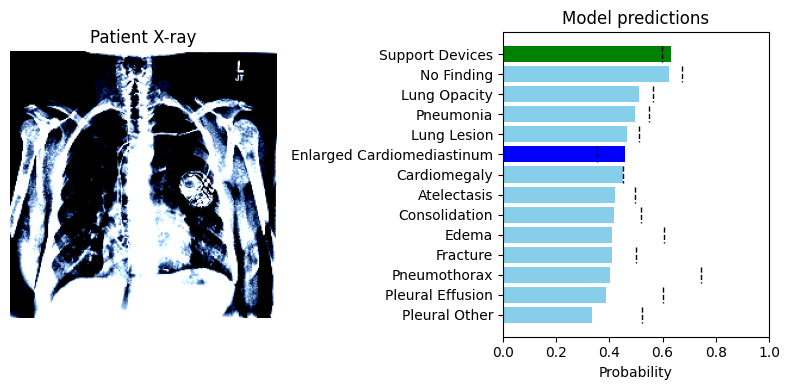

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


Ground truth:
  ✅ Support Devices

Predicted labels (thresholded):
  Enlarged Cardiomediastinum: 0.46
  Support Devices: 0.63
--------------------------------------------------


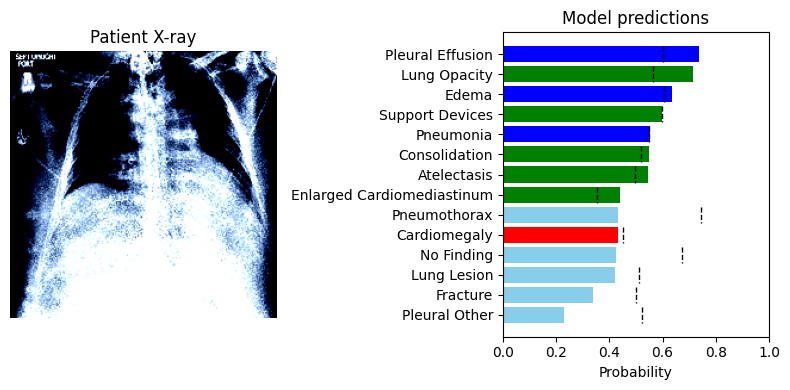

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


Ground truth:
  ✅ Enlarged Cardiomediastinum
  ✅ Cardiomegaly
  ✅ Lung Opacity
  ✅ Consolidation
  ✅ Atelectasis
  ✅ Support Devices

Predicted labels (thresholded):
  Enlarged Cardiomediastinum: 0.44
  Lung Opacity: 0.71
  Edema: 0.63
  Consolidation: 0.55
  Pneumonia: 0.55
  Atelectasis: 0.54
  Pleural Effusion: 0.74
  Support Devices: 0.60
--------------------------------------------------


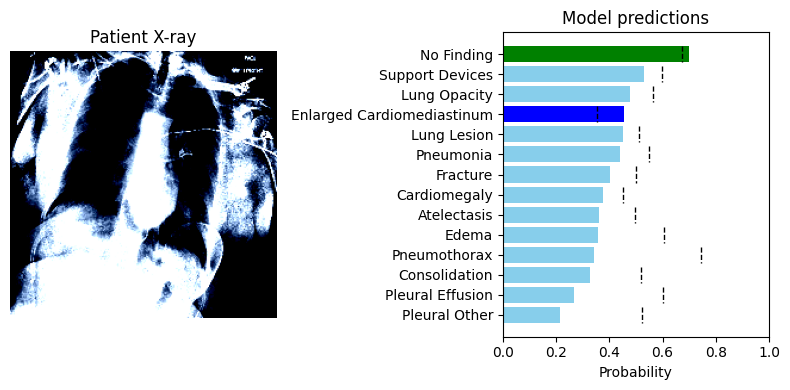

Ground truth:
  ✅ No Finding

Predicted labels (thresholded):
  No Finding: 0.70
  Enlarged Cardiomediastinum: 0.46
--------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


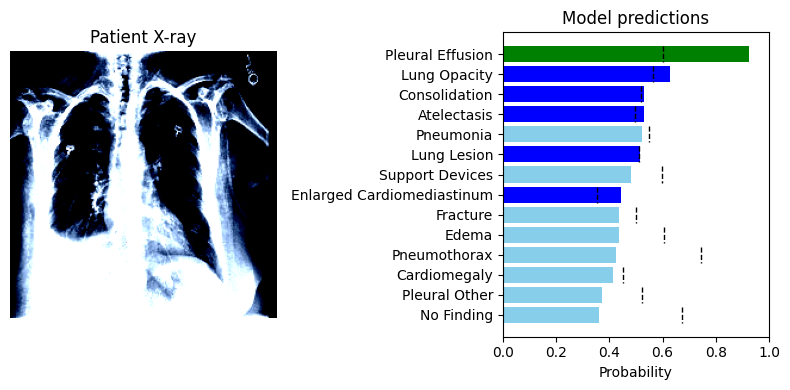

Ground truth:
  ✅ Pleural Effusion

Predicted labels (thresholded):
  Enlarged Cardiomediastinum: 0.44
  Lung Opacity: 0.63
  Lung Lesion: 0.52
  Consolidation: 0.53
  Atelectasis: 0.53
  Pleural Effusion: 0.92
--------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


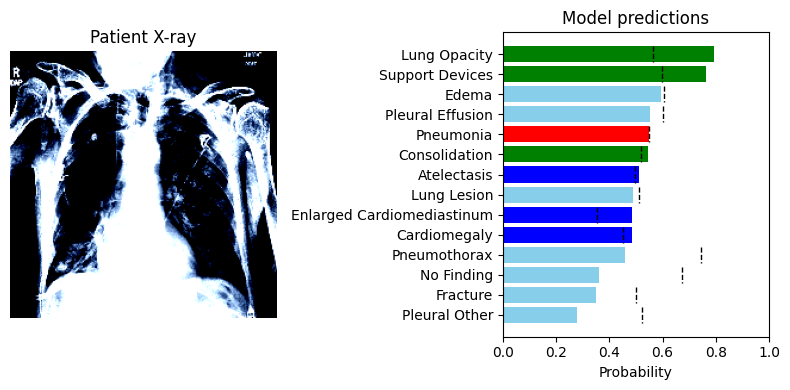

Ground truth:
  ✅ Lung Opacity
  ✅ Consolidation
  ✅ Pneumonia
  ✅ Support Devices

Predicted labels (thresholded):
  Enlarged Cardiomediastinum: 0.49
  Cardiomegaly: 0.49
  Lung Opacity: 0.79
  Consolidation: 0.54
  Atelectasis: 0.51
  Support Devices: 0.76
--------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


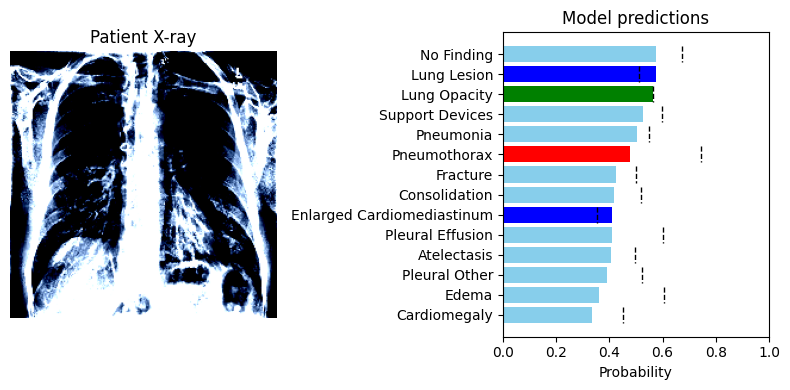

Ground truth:
  ✅ Lung Opacity
  ✅ Pneumothorax

Predicted labels (thresholded):
  Enlarged Cardiomediastinum: 0.41
  Lung Opacity: 0.57
  Lung Lesion: 0.57
--------------------------------------------------


In [27]:
# Run predictions
show_predictions(ensemble_models, val_dataset, device, thresholds, num_samples=6)